In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
import itertools

In [89]:
## Read window-based pi, Tajima's D, and Fst 
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'

db = 'indInd'
file_name_pi = 'PopGen_{}/passed.{}_full_final.10k.windowed.pi'.format(db, db)
file_name_D = 'PopGen_{}/passed.{}_full_final.10k.Tajima.D'.format(db, db)
file_name_fst = 'PopGen_{}/tree_vs_ground_Fst_10kb.windowed.weir.fst'.format(db)

file_data_pi = glob(dir_path + file_name_pi)[0]
file_data_D = glob(dir_path + file_name_D)[0]
file_data_fst = glob(dir_path + file_name_fst)[0]
df_pi = pd.read_csv(file_data_pi, sep='\t')
df_D = pd.read_csv(file_data_D, sep='\t')
df_fst = pd.read_csv(file_data_fst, sep='\t')

df_pi.head()

,CHROM,SCAFFOLD,BIN_START,BIN_END,N_VARIANTS,PI
0,chr1,CM051081,1,10000,23,0.000247
1,chr1,CM051081,20001,30000,20,0.000235
2,chr1,CM051081,30001,40000,165,0.002763
3,chr1,CM051081,40001,50000,190,0.003545
4,chr1,CM051081,50001,60000,155,0.002876


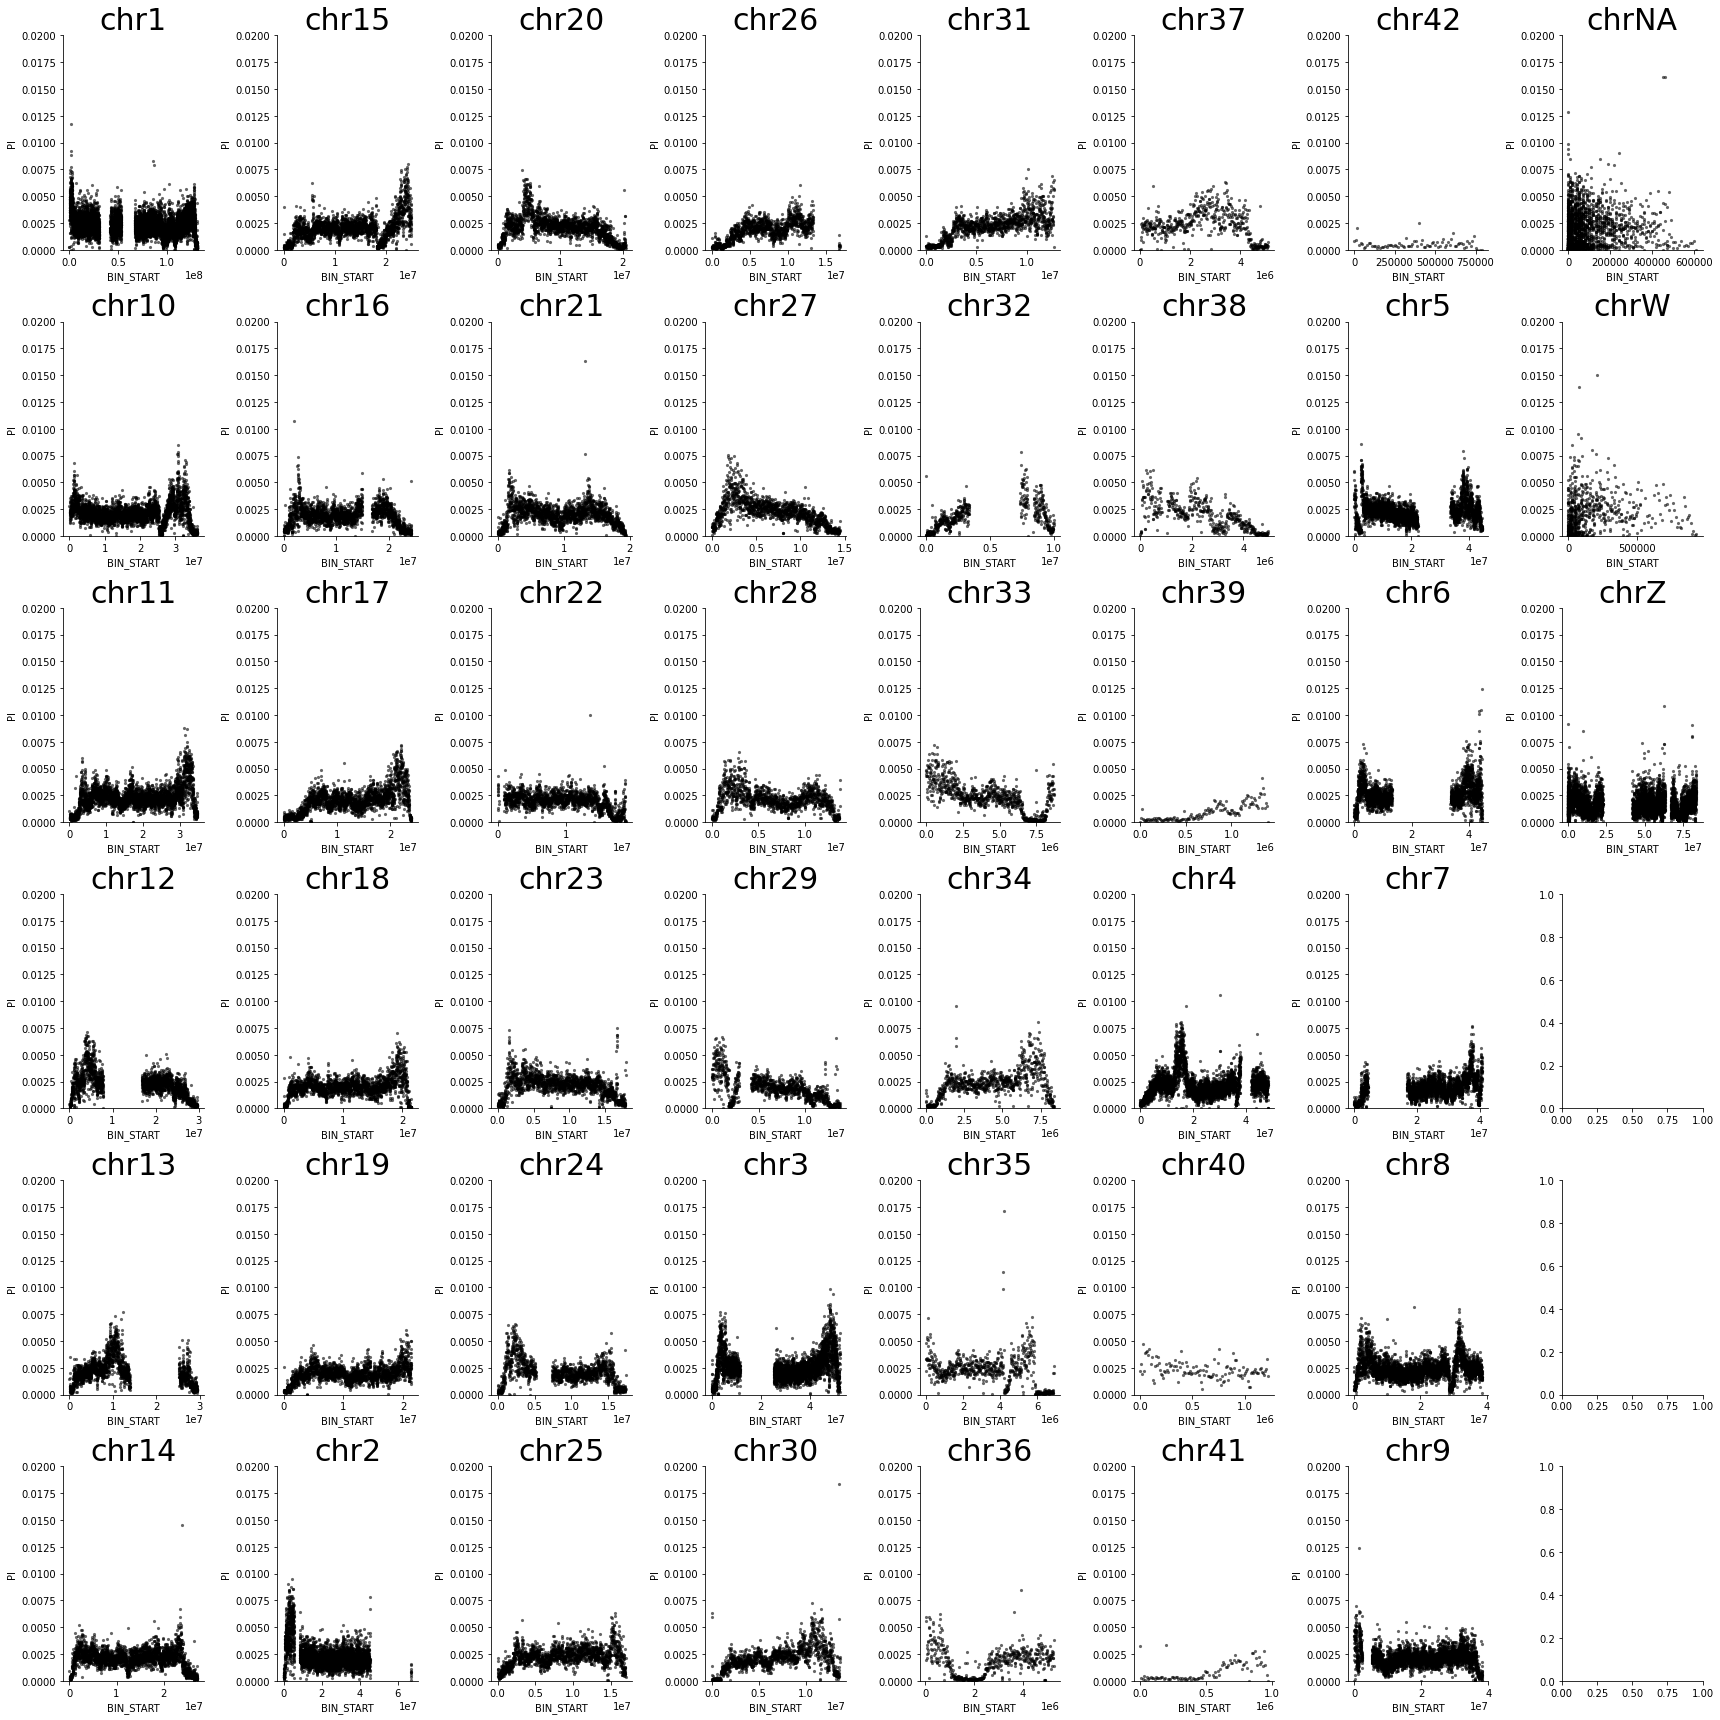

In [91]:
## Plot sliding window chr by chr
all_chroms = sorted(list(set(df_pi['CHROM'])))

fig, axes = plt.subplots(6, 8, figsize=(3*8, 4*6))

for j in range(8):
    for i in range(6):        
        k = 6 * j + i
        try:
            chri = all_chroms[k]
        except IndexError:
            break
            
        axi = axes[i][j]
        chri = all_chroms[k]
        dfi = df_pi[df_pi['CHROM'] == chri]
        sns.scatterplot(ax=axi, data=dfi, x='BIN_START', y='PI', s=10, linewidth=0, alpha=0.6)
        axi.set(ylim=(0, 0.02))
        axi.set_title(chri, fontsize=30)  
        sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
        fig.tight_layout()

In [132]:
def make_position(dfi):
    ## sorts by chromosome number and adds absolute postion column
    
    dfi = dfi.dropna()
    exclude = ['chrZ', 'chrW', 'chrNA']
    dfi['COUNT'] = dfi['CHROM'].str.replace('chr', '')
    
    dfi_num = dfi[ ~dfi['CHROM'].isin(exclude)]
    dfi_Z = dfi[dfi['CHROM'] == 'chrZ']
    dfi_W = dfi[dfi['CHROM'] == 'chrW']
    
    dfi_num['COUNT'] = pd.to_numeric(dfi_num['COUNT'])
    dfi_num.sort_values(by=['COUNT'])
    
    dfi_merged = pd.concat([dfi_num, dfi_Z, dfi_W], ignore_index=True)
    dfi_merged['POSITION'] = [x / 100 for x in range(dfi_merged.shape[0])]
    return dfi_merged

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


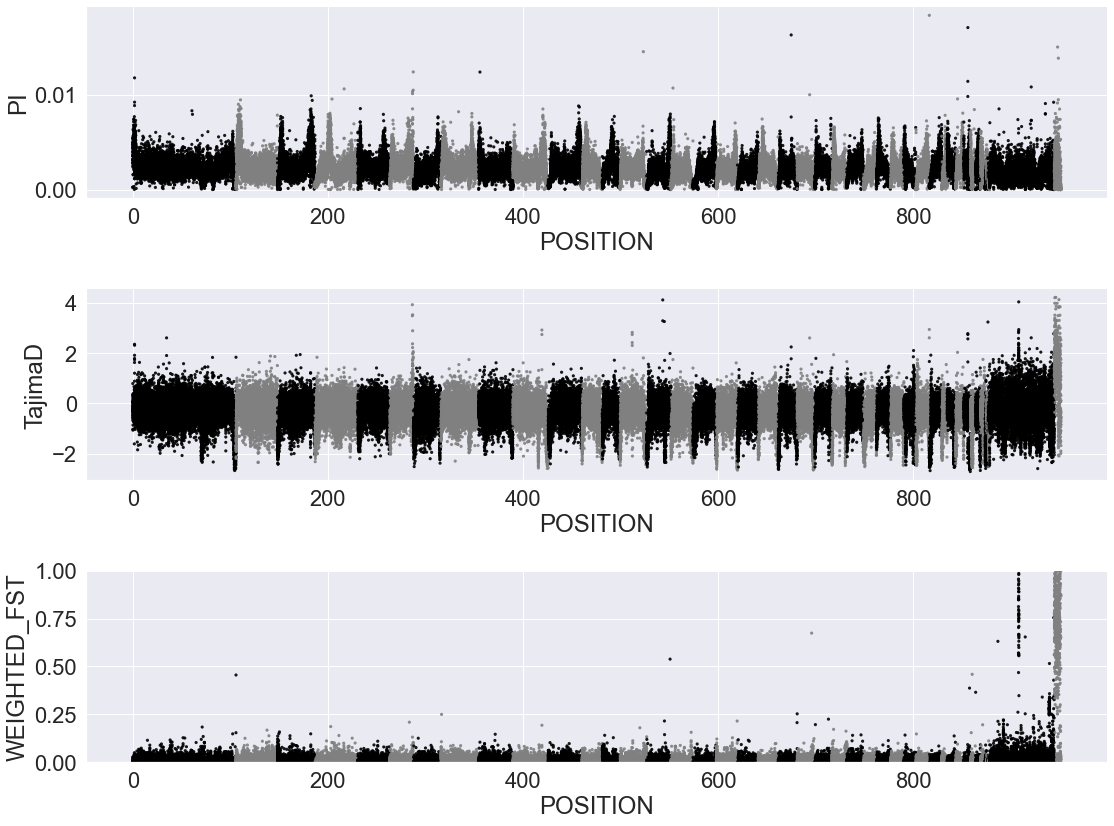

In [145]:
## Plot by window position sccross the whole genome
# exclude = ['chrZ', 'chrW', 'chrNA']
df_pi_sorted = make_position(df_pi)
df_D_sorted = make_position(df_D)
df_fst_sorted = make_position(df_fst)

fig, axes = plt.subplots(3, 1, figsize=(16, 4*3))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
p = ['black', 'grey'] * int(len(set(df_pi_sorted['COUNT'])) / 2)
sns.set_palette(p)

## pi
sns.scatterplot(ax=ax1, data=df_pi_sorted, x='POSITION', y='PI', hue='CHROM', 
                s=10, linewidth=0, alpha=0.9, palette=p)
## Tajima's D
sns.scatterplot(ax=ax2, data=df_D_sorted, x='POSITION', y='TajimaD', hue='CHROM', 
                s=10, linewidth=0, alpha=0.9, palette=p)
## Fst
sns.scatterplot(ax=ax3, data=df_fst_sorted, x='POSITION', y='WEIGHTED_FST', hue='CHROM', 
                s=10, linewidth=0, alpha=0.9, palette=p)
# ## Fst no chrZ, chrW
# sns.scatterplot(ax=ax4, data=df_fst_sorted[ ~df_fst_sorted['CHROM'].isin(exclude)],
#                 x='POSITION', y='WEIGHTED_FST', hue='CHROM', 
#                 s=10, linewidth=0, alpha=0.9, palette=p[:-2])
ax3.set(ylim = (0, 1))
# ax4.set(ylim = (0, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
ax1.legend([], [], frameon=False)
ax2.legend([], [], frameon=False)
ax3.legend([], [], frameon=False)

fig.tight_layout()

pdf_name = 'pi_TajimaD_Fst.{}.by_chromosome.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')